In [40]:
import os
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain

import warnings
warnings.filterwarnings("ignore")

In [41]:
def initial_condition_function(x):
    return torch.sin(torch.pi * x)

def boundary_condition_function(x, t):
    return torch.sin(torch.pi * x * t)

def analytical_solution(x, t, alpha, L):
    sum_terms = 0
    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition_function(x) * np.sin(n * np.pi * x / L), 0, L)
        sum_terms += 2 / L * B_n * np.sin(n * np.pi * x / L) * np.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return sum_terms

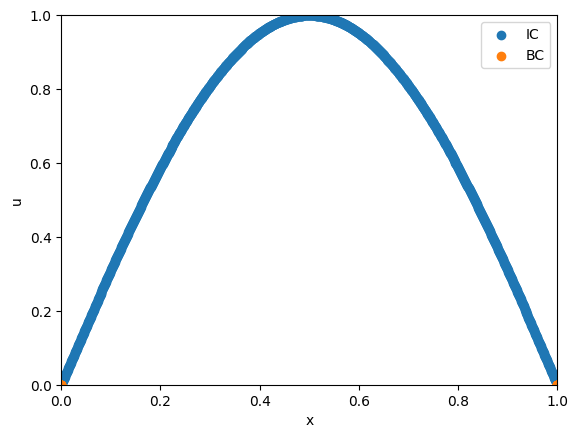

In [49]:
geom = geometry.Interval(0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)

initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=1000, random=False, device="cuda:0")
boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=1000, random=False, device="cuda:0")
equation = conditions.Equation()
equation.set_equation(geom=geom, time=period, num_points=1000, random=False, device="cuda:0")

problem = conditions.Problem(initial_conditions, boundary_conditions, equation, geom, period, alpha=0.1)

problem.visualize(0.0)

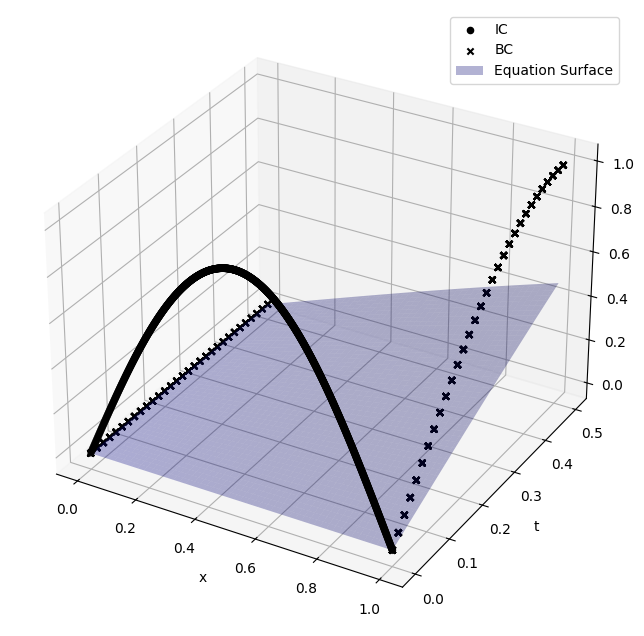

In [44]:
def plot_3d_points(x_initial, t_initial, u_initial, 
                   x_boundary, t_boundary, u_boundary,
                   x_equation=None, t_equation=None, u_equation=None):
    # TODO: as input use problem.initial_conditions, problem.boundary_conditions and problem.equation
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(to_numpy(x_initial), to_numpy(t_initial), to_numpy(u_initial), 
               c='black', marker='o', label='IC')
    ax.scatter(to_numpy(x_boundary), to_numpy(t_boundary), to_numpy(u_boundary), 
               c='black', marker='x', label='BC')

    if x_equation is not None:
         ax.plot_surface(to_numpy(x_equation), to_numpy(t_equation), to_numpy(u_equation), 
                         color='blue', alpha=0.3, label='Equation Surface')

    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.legend()

    plt.show()

def to_numpy(tensor):
        return tensor.cpu().detach().numpy()

x_initial, t_initial, u_initial = problem.initial_conditions.get_initial_conditions()
x_boundary, t_boundary, u_boundary = problem.boundary_conditions.get_boundary_conditions()

# Not actual equation surface
x_equation, t_equation = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 0.5, 100))
u_equation = torch.sin(x_equation * t_equation)

plot_3d_points(x_initial, t_initial, u_initial, 
               x_boundary, t_boundary, u_boundary,
               x_equation=x_equation, t_equation=t_equation, u_equation=u_equation)

In [38]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML # Need for GIF visualization in Jupyter Notebook

def generate_data(num_points=100):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    phi = np.random.uniform(0, np.pi, num_points)
    radius = np.random.uniform(0, 1, num_points)
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return x, y, z

def problem_gif(x, t, u, frames, output_path='animation.gif'):
    # Visualization for 2D solution
    # TODO: implement visualization for 1D solution (as a plot on x t coordinates where color is temperature and cutting line goes up)
    # TODO: as input use problem.initial_conditions, problem.boundary_conditions and problem.equation
    images = []

    x_lim = (x.min(), x.max())
    t_lim = (t.min(), t.max())
    u_lim = (u.min(), u.max())

    u_range = np.linspace(u.min(), u.max(), frames)
    
    dense_x = np.linspace(x.min(), x.max(), 10)
    dense_t = np.linspace(t.min(), t.max(), 10)
    xx, tt = np.meshgrid(dense_x, dense_t)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, u_cut in enumerate(u_range):
        under_plane = u < u_cut

        ax.scatter(x[under_plane], t[under_plane], u[under_plane], 
                   c=u[under_plane], marker='o')
        
        ax.plot_surface(xx, tt, np.full_like(xx, u_cut), alpha=0.2)

        ax.set_xlim(x_lim)
        ax.set_ylim(t_lim)
        ax.set_zlim(u_lim)

        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u')

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
        ax.clear()

    imageio.mimsave(output_path, images, fps=10)
    plt.close(fig)

x, t, u = generate_data(1000)
output_path = 'animation.gif'
problem_gif(x, t, u, frames=100, output_path=output_path)
HTML(f'<img src="{output_path}" width="500" height="500">')

C:\Users\alex\AppData\Local\Temp\ipykernel_30524\4108379085.py:49: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


In [47]:
net_params = utils.NetParams()
# TODO: add EarlyStopping, HybridOptimizer, rar_points, LossWeightAdjuster to parameters
net_params.set_params(input=2,
                      output=1,
                      hidden_layers=[int(40) for _ in range(4)],
                      epochs=10000,
                      batch_size=1000,
                      learning_rate=0.001,
                      activation='tanh',
                      training_mode='train',
                      optimizer='Adam',
                      display_interval=100,
                      model_save_path='models',
                      output_path='out',
                      initial_weights_path=None,
                      siren_params=None)

# Or load from json file
# net_params.from_json_file("params.json")

In [50]:
model = pinn.PINN(problem, net_params, device='cuda:0')
model.train()

test = problem.test.set_test(geom = geom, time = period, 
                             num_points = 100, random=False, device="cuda:0")
u_pinn = model.predict(test.x, test.t)
u_analytical = analytical_solution(test.x.cpu().detach().numpy(), 
                                   problem.time.t1, problem.alpha, 
                                   problem.geom.length())

# Plot of solutions
utils.comparison_plot(test.x, u_analytical, u_pinn, model.output_folder)
# Plot loss
utils.loss_history_plot(model.get_loss_history(), model.output_folder)
# L2 norm between analytical and PINN solutions
l2_norm = np.sqrt(np.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

TypeError: str is not a Module subclass

In [10]:
# TODO: add EarlyStopping, HybridOptimizer, rar_points, LossWeightAdjuster to pinn.py

### Test of architecture

Siren parameters:  <solver.siren.SirenParams object at 0x00000225A8712150>
Activation Function: str
Hidden Dimensions: 3
Number of neurons: 20
----------
Layer 0: SineLayer(
  (linear): Linear(in_features=2, out_features=20, bias=True)
) -> SineLayer
Layer 1: SineLayer(
  (linear): Linear(in_features=20, out_features=20, bias=True)
) -> SineLayer
Layer 2: SineLayer(
  (linear): Linear(in_features=20, out_features=20, bias=True)
) -> Linear
Layer 3: Linear(in_features=20, out_features=1, bias=True)
----------
L2 norm: 1.4382039079897646


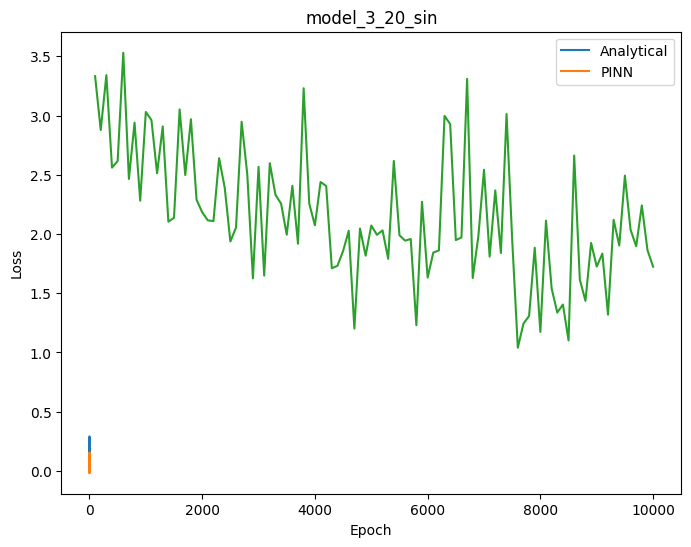

In [ ]:
mesh_params = pinn.MeshParams(size = size,
                              time = time,
                              alpha = alpha,
                              initial_points = initial_points, 
                              boundary_points = boundary_points, 
                              equation_points = equation_points)

siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                 hidden_omega_0 = 30.0,
                                 outermost_linear = True)

net_params = pinn.NetParams(input = 2,
                            output = 1,
                            hidden_layers = [int(20) for _ in range(int(3))],
                            activation = "sin",
                            training_mode = 'full',
                            optimizer = 'Adam',
                            siren_params = siren_params)

model = pinn.PINN(mesh_params, net_params, initial_conditions, boundary_conditions, equation, device='cuda:0')
model.train()

test = conditions.set_test(mesh_params.size, 100, mesh_params.time)
u_pinn = model.predict(test.x, test.t).cpu().detach().numpy()

u_analytical = analytical_solution(test.x.cpu().detach().numpy(), mesh_params.time, alpha, mesh_params.size)

title = f'model_{len(net_params.hidden_layers)}_{net_params.hidden_layers[0]}_{net_params.activation}'
# Plot of solution
make_plot(test.x.cpu().detach().numpy(), u_analytical, u_pinn, model.output_folder, title)
# Plot loss
make_loss_history_plot(model.get_loss_history(), model.output_folder, title)

l2_norm = np.sqrt(np.sum((u_analytical - u_pinn)**2) / len(u_analytical))
print(f'L2 norm: {l2_norm}')

# torch.save(model.net.state_dict(), 
#             os.path.join(weights_dir, f'model_{hidden_layer}_{activation}_{neurons}.pt'))

In [ ]:
output_folder = 'train_img'
os.listdir(output_folder)
images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]
imageio.mimsave(os.path.join(os.getcwd(), 'animation.gif'), images, fps=5, duration=0.1, loop=0)

C:\Users\dsash\AppData\Local\Temp\ipykernel_7436\1830411550.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]


In [ ]:
pinn = pinn.PINN(initial_conditions, boundary_conditions, equation, alpha=0.5)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

test = conditions.set_test(size, 100, time)

x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u_pinn = pinn.function(x_test, t_test)

### Analytical solution for 2D

In [ ]:
def analytical_solution(x, y):
    l_x = 1.0
    l_y = 1.0
    u_1 = 1.0
    u_2 = 5.0
    lambda_n = [n * np.pi / l_x for n in range(1, 52)]
    return (u_1 + (u_2 - u_1) * (x / l_x)
    + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))

### Analytical solution for 1D and comparison with FDM

In [ ]:
def initial_condition(x):
    return np.sin(np.pi * x)

def analytical_solution(x, t, alpha, L):
    sum_terms = 0
    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition(x) * np.sin(n * np.pi * x / L), 0, L)
        sum_terms += 2 / L * B_n * np.sin(n * np.pi * x / L) * np.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return sum_terms

In [ ]:
def fdm_solver(L, T, num_points, alpha):
    dx = L / (num_points - 1)
    dt = 0.1 * dx**2 / alpha
    r = alpha * dt 

    x_values = np.linspace(0, L, num_points)
    u_values = np.zeros((num_points, int(T / dt) + 1))

    u_values[:, 0] = initial_condition(x_values)

    # Time-stepping with explicit finite difference scheme
    for n in range(1, int(T / dt) + 1):
        for i in range(1, num_points - 1):
            u_values[i, n] = (u_values[i, n - 1] + alpha**2 * dt *
                              (u_values[i + 1, n - 1] - 2 * u_values[i, n - 1] + u_values[i - 1, n - 1]) / dx**2)

    return x_values, u_values

In [ ]:
def comparison_plot(x_values, u_fdm, u_analytical, u_pinn):
    plt.figure(figsize=(8, 6))
    plt.xlabel('x')
    plt.ylabel('temperature')

    plt.plot(x_values, u_fdm, label='FDM')
    plt.plot(x_values, u_analytical, label='Analytical')
    plt.plot(x_values, u_pinn, label='PINN')
    plt.legend()
    plt.show()

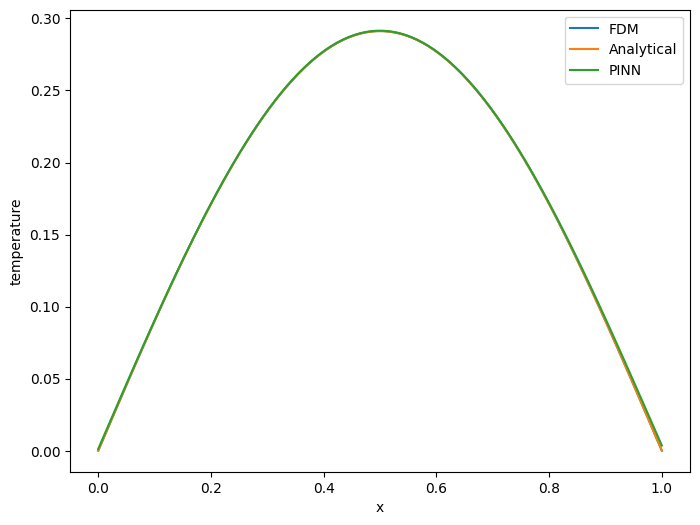

In [ ]:
# Parameters
L = 1.0  # Length
T = 0.5  # Total simulation time
num_points = 100  # Number of spatial grid points
alpha = 0.5  # Thermal diffusivity

# Solve heat equation numerically
x, u_fdm = fdm_solver(L, T, num_points, alpha)
u_fdm = u_fdm[:, -1]

u_analytical = analytical_solution(x, T, alpha, L)

test = conditions.set_test(L, 100, T)
x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u_pinn = pinn.predict(x_test, t_test).detach().numpy()

# Plot numerical vs analytical solution
comparison_plot(x, u_fdm, u_analytical, u_pinn)

In [ ]:
def l2_norm(u1, u2):
    return np.sqrt(np.sum((u1 - u2)**2) / len(u1))

l2_norm_fdm = l2_norm(u_fdm, u_analytical)
l2_norm_pinn = l2_norm(u_pinn, u_analytical)

print(f"L2 norm (FDM vs Analytical): {l2_norm_fdm}")
print(f"L2 norm (PINN vs Analytical): {l2_norm_pinn}")

L2 norm (FDM vs Analytical): 2.0006872687507824e-05
L2 norm (PINN vs Analytical): 1.2844777324290277
